### Just use MPC to split into missense benign and pathogenic
* missense vars must have missense score

In [45]:
import pandas as pd
import numpy
from scipy.stats import entropy
import pydot, pydotplus, graphviz
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn import linear_model, metrics, tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.externals.six import StringIO
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier
from IPython.display import HTML
%matplotlib inline

In [46]:
cols = ['mpc']
key_cols = ['chrom', 'pos', 'ref', 'alt']

right_benign = "#32CD32"
right_path = "#2ecc71"
wrong_path = "#e74c3c"
wrong_benign = "#ffcccb"
flatui = [right_benign, right_path, wrong_benign, wrong_path]

def eval_pred(row, col):
    if row[col] == row['y']:
        if row['y'] == 1:
            return 'CorrectPath'
        return 'CorrectBenign'
    if row['y'] == 1:
        return 'WrongPath'
    return 'WrongBenign'

def eval_df():
    pass

In [47]:
# train gene dx: missense, only focus genes
dat_file = '../data/interim/EPIv6.eff.dbnsfp.anno.hHack.dat.limit.xls'
train_df = pd.read_csv(dat_file, sep='\t')
train_df.loc[:, 'y'] = train_df.apply(lambda row: 1 if row['class']=='P' else 0, axis=1)
train_keys = {':'.join([str(x) for x in v]):True for v in train_df[key_cols].values}
tree_clf = tree.DecisionTreeClassifier(max_depth=1)
X, y = train_df[cols], train_df['y']
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.4/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:/

,PredictionStatusMPC,size
0,CorrectBenign,21
1,CorrectPath,7
2,WrongBenign,1
3,WrongPath,1


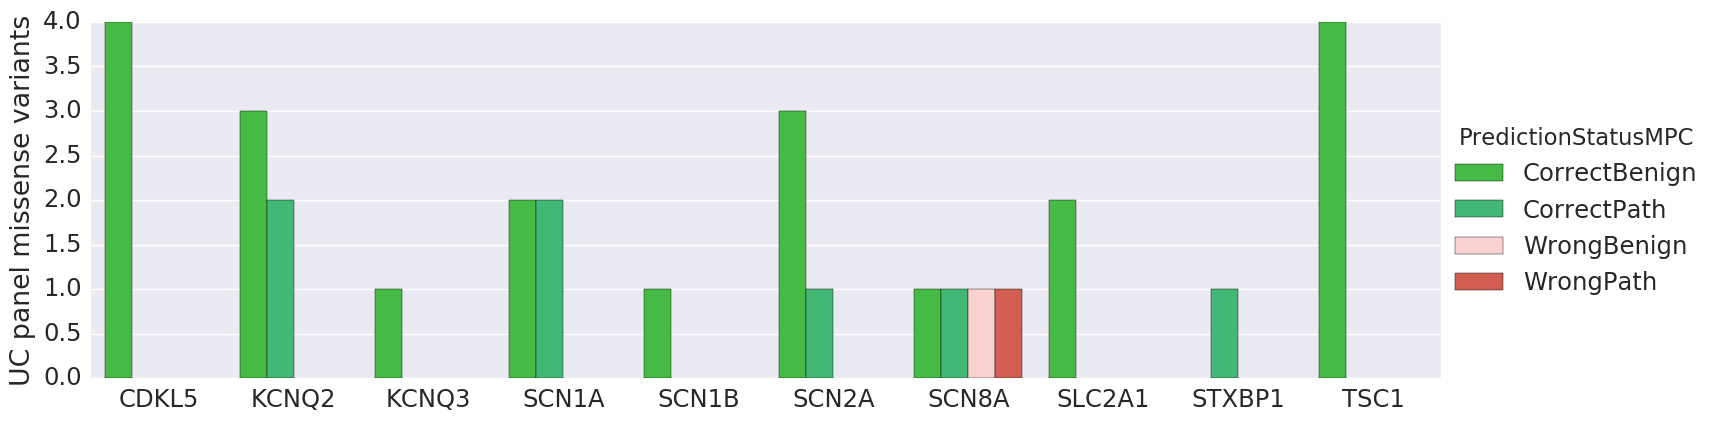

In [51]:
# test uc data
# rm training data
dat_file = '../data/interim/uc.eff.dbnsfp.anno.hHack.dat.limit.xls'
test_df_pre = pd.read_csv(dat_file, sep='\t')
test_df_pre.loc[:, 'key'] = test_df_pre.apply(lambda row: ':'.join([str(row[x]) for x in key_cols]), axis=1)
test_df_pre.loc[:, "not_in_training"] = test_df_pre.apply(lambda row: not row['key'] in train_keys, axis=1)
test_df = test_df_pre[test_df_pre.not_in_training]
test_df.loc[:, 'y'] = test_df.apply(lambda row: 1 if row['class']=='P' else 0, axis=1)
X_test = test_df[cols]
preds = tree_clf.predict(X_test)
test_df['mpc_pred'] = preds
test_df.loc[:, 'PredictionStatusMPC'] = test_df.apply(lambda row: eval_pred(row, 'mpc_pred'), axis=1)
#test_df.head()
g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC']]
        .groupby(['gene', 'PredictionStatusMPC'])
        .size().reset_index().rename(columns={0:'size'}))
dd = g_df.groupby('gene').sum().reset_index()
sns.set(font_scale=1.75)
ss = sns.factorplot(x='gene', hue='PredictionStatusMPC', y='size', data=g_df,
                    kind='bar', palette=sns.color_palette(flatui), size=5, aspect=3)
ss.set_ylabels('UC panel missense variants')
ss.set_xlabels('')
ss.set_titles('MPC performance')
ss.savefig("../docs/plots/uc_mpc_eval.png")

g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC']]
        .groupby(['PredictionStatusMPC'])
        .size().reset_index().rename(columns={0:'size'}))
g_df.head()

/opt/conda/lib/python3.4/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

,PredictionStatusMPC,size
0,CorrectBenign,36
1,CorrectPath,240
2,WrongBenign,12
3,WrongPath,38


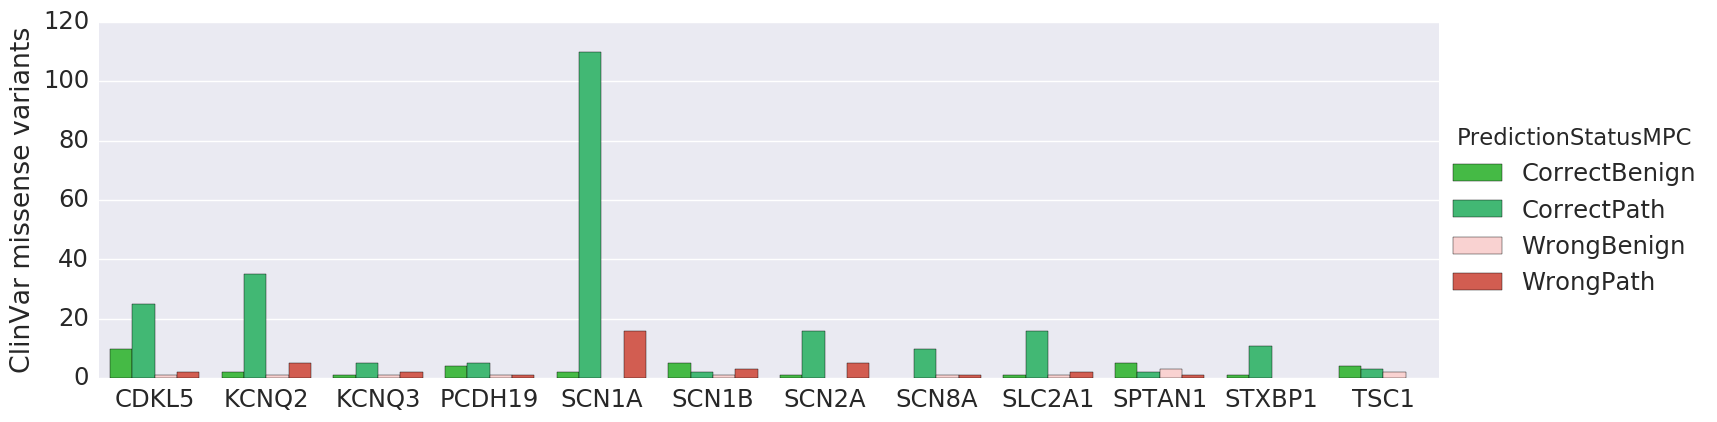

In [52]:
# test clinvar data
# rm training data
dat_file = '../data/interim/clinvar/clinvar.limit.dat'
test_df_pre = pd.read_csv(dat_file, sep='\t').rename(columns={'clin_class':'y'})
test_df_pre.loc[:, 'key'] = test_df_pre.apply(lambda row: ':'.join([str(row[x]) for x in key_cols]), axis=1)
test_df_pre.loc[:, "not_in_training"] = test_df_pre.apply(lambda row: not row['key'] in train_keys, axis=1)
test_df = test_df_pre[test_df_pre.not_in_training]
X_test = test_df[cols]
preds = tree_clf.predict(X_test)
test_df['mpc_pred'] = preds
test_df.loc[:, 'PredictionStatusMPC'] = test_df.apply(lambda row: eval_pred(row, 'mpc_pred'), axis=1)

g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC']]
        .groupby(['gene', 'PredictionStatusMPC'])
        .size().reset_index().rename(columns={0:'size'}))
dd = g_df.groupby('gene').sum().reset_index()

sns.set(font_scale=1.75)
ss = sns.factorplot(x='gene', hue='PredictionStatusMPC', y='size', data=g_df,
                    kind='bar', palette=sns.color_palette(flatui), size=5, aspect=3)
ss.set_ylabels('ClinVar missense variants')
ss.set_xlabels('')
ss.set_titles('MPC performance')
ss.savefig("../docs/plots/clinvar_mpc_eval.png")

g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC']]
        .groupby(['PredictionStatusMPC'])
        .size().reset_index().rename(columns={0:'size'}))
g_df.head()

In [54]:
c = 36+240
w = 12+38
w/(w+c)

0.15337423312883436

/opt/conda/lib/python3.4/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

,PredictionStatusMPC,size
0,CorrectBenign,104
1,CorrectPath,323
2,WrongBenign,31
3,WrongPath,29


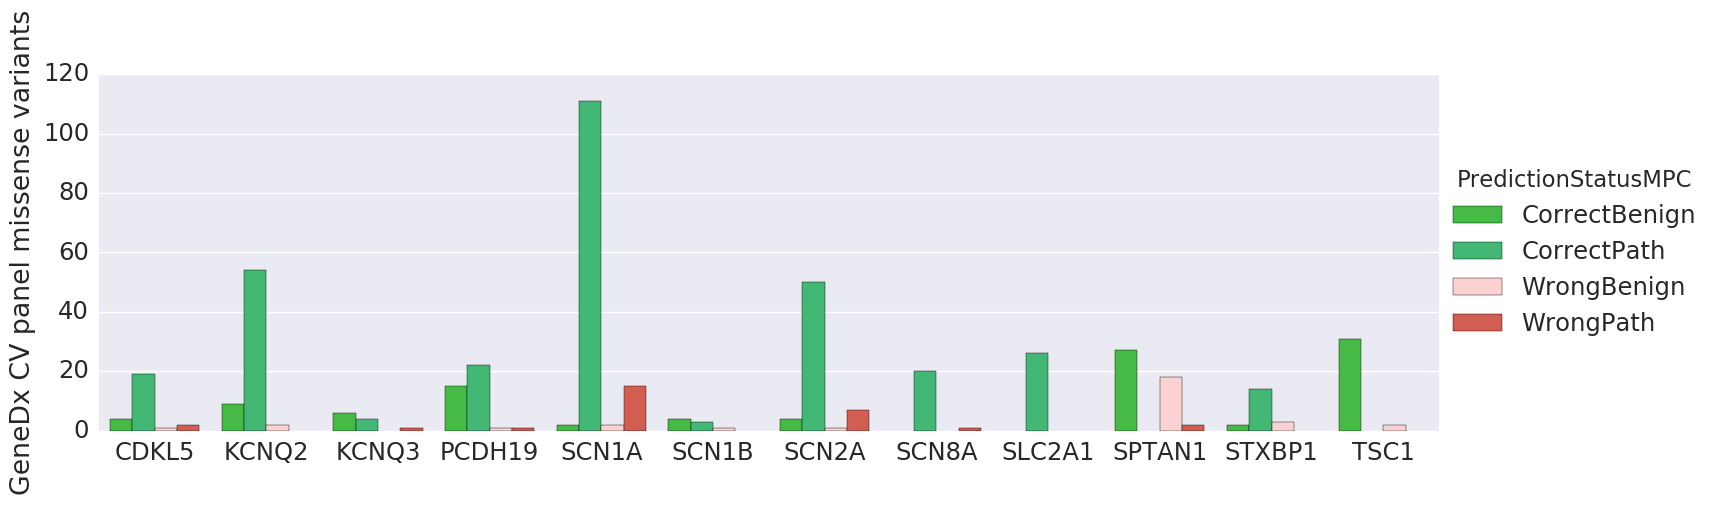

In [53]:
# one gene at a time
acc_df_ls = []
genes = set(train_df['gene'])
for test_gene in genes:
    sub_train_df = train_df[train_df.gene != test_gene]
    tree_clf_sub = tree.DecisionTreeClassifier(max_depth=1)
    X, y = sub_train_df[cols], sub_train_df['y']
    tree_clf_sub.fit(X, y)

    test_df = train_df[train_df.gene == test_gene]
    X_test = test_df[cols]
    preds = tree_clf_sub.predict(X_test)
    test_df['mpc_pred'] = preds
    test_df.loc[:, 'PredictionStatusMPC'] = test_df.apply(lambda row: eval_pred(row, 'mpc_pred'), axis=1)
    acc_df_ls.append(test_df)

test_df = pd.concat(acc_df_ls)    
g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC']]
        .groupby(['gene', 'PredictionStatusMPC'])
        .size().reset_index().rename(columns={0:'size'}))
dd = g_df.groupby('gene').sum().reset_index()

sns.set(font_scale=1.75)
ss = sns.factorplot(x='gene', hue='PredictionStatusMPC', y='size', data=g_df,
                    kind='bar', palette=sns.color_palette(flatui), size=5, aspect=3)
ss.set_ylabels('GeneDx CV panel missense variants')
ss.set_xlabels('')
ss.set_titles('MPC performance')
ss.savefig("../docs/plots/genedx_cv_mpc_eval.png")

g_df = (test_df[['gene', 'chrom', 'pos', 'ref', 'alt', 'PredictionStatusMPC']]
        .groupby(['PredictionStatusMPC'])
        .size().reset_index().rename(columns={0:'size'}))
g_df.head()

In [55]:
c = 104+323
w = 31+29
w/(w+c)

0.12320328542094455